In [1]:
import virusPropagationModel as vPM
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
model = vPM.VirusPropagationModel(100,400,5)

In [3]:
res = model.simulate(100)
res.head()

,h_ID,loc,status,time
0,63,41,S,1
1,64,70,S,1
2,65,7,S,1
3,66,48,S,1
4,67,37,S,1


In [4]:
#for x in ['S','I']:
S =[(t,len(res[(res['time']==t) & (res['status']=='S')])) for t in res['time'].unique() ]
I =[(t,len(res[(res['time']==t) & (res['status']=='I')])) for t in res['time'].unique() ]
R =[(t,len(res[(res['time']==t) & (res['status']=='R')])) for t in res['time'].unique() ]
D =[(t,len(res[(res['time']==t) & (res['status']=='D')])) for t in res['time'].unique() ]
    

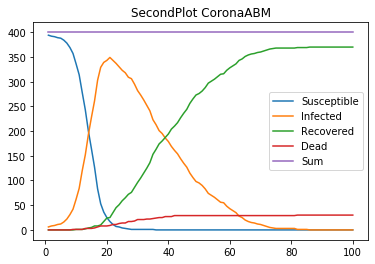

In [5]:
dfS = pd.DataFrame(S, columns=['time', 'S'])
plt.plot(dfS['time'].values, dfS['S'].values, label = 'Susceptible')
dfI = pd.DataFrame(I, columns=['time', 'I'])
plt.plot(dfI['time'].values, dfI['I'].values, label = 'Infected')
dfR = pd.DataFrame(R, columns=['time', 'R'])
plt.plot(dfI['time'].values, dfR['R'].values, label = 'Recovered')
dfD = pd.DataFrame(D, columns=['time', 'D'])
plt.plot(dfD['time'].values, dfD['D'].values, label = 'Dead')

plt.plot(dfI['time'].values, dfR['R'].values+dfI['I'].values+dfS['S'].values + dfD['D'].values, label = 'Sum')
plt.title('SecondPlot CoronaABM')
plt.legend()
plt.savefig('CoronaPlot.png')


Text(0.5, 1.0, 'schedule')

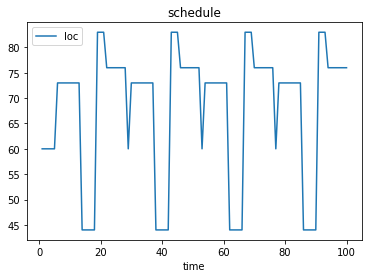

In [6]:
res[res['h_ID']==1].plot('time','loc')
plt.title('schedule')

In [7]:
model.timecourse

[{'h_ID': 63, 'loc': 41, 'status': 'S', 'time': 1},
 {'h_ID': 64, 'loc': 70, 'status': 'S', 'time': 1},
 {'h_ID': 65, 'loc': 7, 'status': 'S', 'time': 1},
 {'h_ID': 66, 'loc': 48, 'status': 'S', 'time': 1},
 {'h_ID': 67, 'loc': 37, 'status': 'S', 'time': 1},
 {'h_ID': 68, 'loc': 77, 'status': 'S', 'time': 1},
 {'h_ID': 69, 'loc': 66, 'status': 'S', 'time': 1},
 {'h_ID': 70, 'loc': 89, 'status': 'S', 'time': 1},
 {'h_ID': 71, 'loc': 24, 'status': 'S', 'time': 1},
 {'h_ID': 72, 'loc': 77, 'status': 'S', 'time': 1},
 {'h_ID': 73, 'loc': 52, 'status': 'S', 'time': 1},
 {'h_ID': 74, 'loc': 94, 'status': 'S', 'time': 1},
 {'h_ID': 75, 'loc': 1, 'status': 'S', 'time': 1},
 {'h_ID': 76, 'loc': 96, 'status': 'S', 'time': 1},
 {'h_ID': 77, 'loc': 93, 'status': 'S', 'time': 1},
 {'h_ID': 78, 'loc': 21, 'status': 'S', 'time': 1},
 {'h_ID': 79, 'loc': 55, 'status': 'S', 'time': 1},
 {'h_ID': 80, 'loc': 66, 'status': 'S', 'time': 1},
 {'h_ID': 81, 'loc': 91, 'status': 'S', 'time': 1},
 {'h_ID': 82, 

In [8]:
res = model.simulate(100)
res

,h_ID,loc,status,time
0,63,41,S,1
1,64,70,S,1
2,65,7,S,1
3,66,48,S,1
4,67,37,S,1
5,68,77,S,1
6,69,66,S,1
7,70,89,S,1
8,71,24,S,1
9,72,77,S,1
